# License Plate Optical Character Recognition

## Import libraries and test CUDA

In [1]:
import numpy as np
import os
import csv
import glob
from matplotlib import pyplot as plt
from paddleocr import PaddleOCR, draw_ocr

## Benchmark data overview

In [2]:
def label_reader(file_path):
    true_labels = {}
    
    with open(file_path) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            true_labels[row[0]] = row[1]
            
    return true_labels
                
true_labels = label_reader('train_data/groundtruth.csv')
len(true_labels)

751

## Ignoring invalid data labels

After looking at the data, I found that there are incorrect labels for some license plates. If the license plate contains only number 0 (say a license plate is 000000), then the label will just be '0', which is incorrect. In the benchmark, I will remove these incorrect samples in `train_data/data_preprocess.ipynb`.

## Test PaddleOCR for character recognition

For the block below, choose 2 models with fine-tuning or without fine-tuning by commenting code

In [3]:
# Without fine-tuning
# ocr = PaddleOCR(lang="en", show_log=False, det=False)

# With fine-tuning
fine_tune_path = 'us_fine_tune_rec/'
ocr = PaddleOCR(lang="en", show_log=False, rec_model_dir=fine_tune_path)

[[[[[19.0, 9.0], [49.0, 9.0], [49.0, 35.0], [19.0, 35.0]],
   ('FEB', 0.9998607635498047)],
  [[[84.0, 12.0], [247.0, 12.0], [247.0, 35.0], [84.0, 35.0]],
   ('ALASKA', 0.9994215965270996)],
  [[[276.0, 11.0], [300.0, 11.0], [300.0, 31.0], [276.0, 31.0]],
   ('11', 0.9999848008155823)],
  [[[60.0, 44.0], [308.0, 42.0], [309.0, 119.0], [61.0, 121.0]],
   ('FUW999', 0.9974930882453918)],
  [[[13.0, 79.0], [50.0, 79.0], [50.0, 90.0], [13.0, 90.0]],
   ('ALASK', 0.9978286623954773)],
  [[[16.0, 92.0], [54.0, 92.0], [54.0, 122.0], [16.0, 122.0]],
   ('0', 0.5380998253822327)],
  [[[79.0, 126.0], [299.0, 126.0], [299.0, 138.0], [79.0, 138.0]],
   ('CELEBRATINGSTATEH00D19592009', 0.9623314142227173)]]]

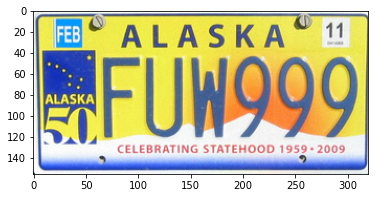

In [4]:
img_path = 'train_data/usimages/ak1165.png'
img = plt.imread(img_path)
plt.imshow(img)

# Suppress warning messages 
import logging
from ppocr.utils.logging import get_logger as ppocr_get_logger
ppocr_get_logger().setLevel(logging.ERROR)

result = ocr.ocr(img_path, cls=True)
result

## PaddleOCR Benchmark

In [5]:
def predict(img_path, reader):
     # this needs to run only once to load the model into memory
    result = reader.ocr(img_path, cls=True)
    img = plt.imread(img_path)
    
    # Check if there are no results
    if not result[0]:
        return '0'
    
    output = []
    for i in range(len(result[0])):
        bbox = result[0][i][0]
        assert len(bbox) == 4, "A bounding box should contain 4 coordinates, got " + str(len(bbox))

        length = np.abs(bbox[1][0] - bbox[0][0])
        width = np.abs(bbox[2][1] - bbox[1][1])
        y_axis = np.average([bbox[0][1], bbox[1][1], bbox[2][1], bbox[3][1]])

        output.append((bbox, result[0][i][1][0], length * width, y_axis))
    
    pred = None
    max_area = max(output,key=lambda item:item[2])
    max_index = output.index(max_area)    
    threshold = img.shape[0] // 12

    for i in range(len(output)):
        if i != max_index and np.abs(output[i][3] - output[max_index][3]) <= 8 and \
           (np.abs(output[i][0][1][1] - output[max_index][0][0][1]) <= threshold or np.abs(output[i][0][0][1] - output[max_index][0][1][1]) <= threshold):
            
            if output[i][0][0][0] < output[max_index][0][0][0]:
                pred = output[i][1] + output[max_index][1]
            else:
                pred = output[max_index][1] + output[i][1]

    if not pred:
        pred = output[max_index][1]

    pred
            
    return pred

In [6]:
all_images = glob.glob(os.path.join('train_data/usimages/', '*.png'))

## Measure accuracy

In [7]:
incorrect_samples = []
num_correct = 0
total_num = len(all_images)
for img in all_images:
    pred_label = predict(img, ocr)
    pred_label = "".join(ch.upper() for ch in pred_label if ch.isalnum())

    img_id = img.split('/')[-1]
    if pred_label == true_labels[img_id]:
        num_correct += 1
    else:
        incorrect_samples.append((img, pred_label))
        
print('The final accuracy is %.2f%%' % ((num_correct / total_num) * 100))

The final accuracy is 84.18%


## Identify fail cases

In [8]:
index = np.random.randint(0, len(incorrect_samples)-1)
actual = true_labels[incorrect_samples[index][0].split('/')[-1]]
incorrect_samples[index][0]

'train_data/usimages/nj891.png'

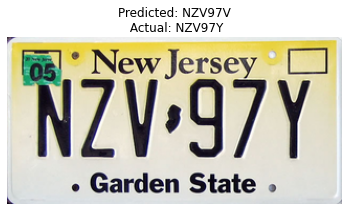

In [9]:
plt.axis('off')
plt.title('Predicted: ' + incorrect_samples[index][1] + '\n Actual: ' + actual)
plt.imshow(plt.imread(incorrect_samples[index][0]))